<a href="https://colab.research.google.com/github/flohmannjr/Carvana-Predict-Car-Prices/blob/main/Carvana_Predict_Car_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carvana - Predict Car Prices

https://www.kaggle.com/datasets/ravishah1/carvana-predict-car-Preços

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.neural_network import MLPRegressor
# from sklearn.svm import SVR
# from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
# from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# import tensorflow as tf

# from tensorflow.data import AUTOTUNE, Dataset
# from tensorflow.keras import Sequential
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.optimizers import Adam

# Configurações

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-darkgrid')

## Constantes

In [3]:
SEMENTE = 2008193

# TAMANHO_CNN = 128
# TAMANHO_SAIDA = 1

# ATIVACAO_CNN = 'relu'
# ATIVACAO_SAIDA = 'linear'

# PERDA = 'mse'
# APRENDIZADO = 0.001

# TAMANHO_LOTE = 256

# ITERACOES = 1000
# INICIALIZADOR = 'he_normal'

# Funções

In [4]:
def obter_metricas(y_test, y_pred):

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)

    return {'Mean Absolute Error': mae,
            'Root Mean Squared Error': rmse,
            'Mean Absolute Percentage Error': mape}

# def obter_modelos(dados_treino,
#                   dados_teste,
#                   modelos_por_perda=5,
#                   iteracoes=1000,
#                   funcoes_perda=['mae', 'mse', 'mape']):

#     conjunto_modelos = []

#     for m in range(modelos_por_perda):

#         for perda in funcoes_perda:

#             modelo_nome = f'conjunto_modelo_{m}_perda_{perda}'

#             print(f"Treinando modelo {modelo_nome} com {iteracoes} iterações.")

#             modelo = Sequential(name=modelo_nome)

#             [modelo.add(Dense(units=TAMANHO_CNN, kernel_initializer=INICIALIZADOR, activation=ATIVACAO_CNN, name=f'camada_relu_{c}')) for c in range(4)]
#             modelo.add(Dense(units=TAMANHO_SAIDA, activation=ATIVACAO_SAIDA, name='camada_saida'))

#             modelo.compile(loss=perda, optimizer=Adam(learning_rate=APRENDIZADO))
            
#             modelo.fit(dados_treino,
#                        epochs=iteracoes,
#                        validation_data=dados_teste,
#                        callbacks=[EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True),
#                                   ReduceLROnPlateau(monitor='val_loss', patience=50)],
#                        verbose=0)
            
#             conjunto_modelos.append(modelo)

#     return conjunto_modelos

# def obter_previsoes(modelos, dados_teste):
    
#     conjunto_previsoes = []

#     for modelo in modelos:

#         print(f'Prevendo com modelo {modelo.name}.')

#         previsoes = modelo.predict(dados_teste)

#         conjunto_previsoes.append(previsoes)
    
#     return tf.constant(tf.squeeze(conjunto_previsoes))

# Dados

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/Carvana-Predict-Car-Prices/main/carvana.csv')

In [6]:
df = df.rename(columns={'Name': 'Descrição', 'Year': 'Ano', 'Miles': 'Milhagem', 'Price': 'Preço'})

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Descrição  22000 non-null  object
 1   Ano        22000 non-null  int64 
 2   Milhagem   22000 non-null  int64 
 3   Preço      22000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 687.6+ KB


## Pré-processamento

In [8]:
# df['Ano'].value_counts()

In [9]:
df['Ano'] = df['Ano'].astype(str).str[:4].astype(int)

In [10]:
# df.duplicated().sum()

In [11]:
df.drop_duplicates(inplace=True)

In [12]:
descricao = df['Descrição'].str.split()

df['Marca']       = descricao.str[0]
df['Modelo']      = descricao.str[1:].str.join(' ')
df['Esporte']     = 1 if 'Sport' in descricao else 0
df['Conversível'] = 1 if 'Cab' in descricao else 0

In [13]:
# len(df['Marca'].unique()), len(df['Modelo'].unique())

In [14]:
df.drop('Descrição', axis=1, inplace=True)

In [15]:
# df = pd.get_dummies(df)

In [16]:
df['Marca']  = df['Marca'].astype('category').cat.codes
df['Modelo'] = df['Modelo'].astype('category').cat.codes

In [17]:
df[:5]

,Ano,Milhagem,Preço,Marca,Modelo,Esporte,Conversível
0,2018,41946,16990,6,350,0,0
1,2020,45328,23990,11,338,0,0
2,2012,81068,21590,17,370,0,0
3,2019,35372,21590,17,265,0,0
4,2017,68992,22990,3,372,0,0


In [18]:
df['Ano'].value_counts()

2016    1077
2017    1075
2015     977
2018     968
2019     941
2020     907
2021     817
2014     810
2013     638
2012     440
2022     278
2011     202
2010     133
2009      52
2023       3
Name: Ano, dtype: int64

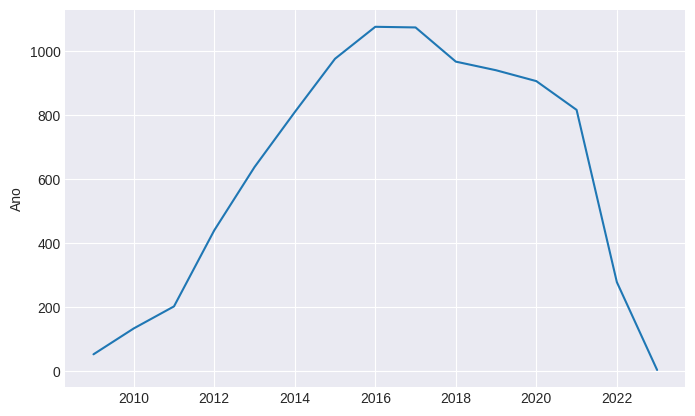

In [19]:
sns.lineplot(data=df['Ano'].value_counts());

## Separação treino e teste

In [20]:
X = df.drop('Preço', axis=1)
y = df['Preço']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEMENTE)

In [22]:
# scaler = MinMaxScaler()
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Criação de datasets

In [23]:
# dataset_X_train    = Dataset.from_tensor_slices(X_train)
# dataset_X_test     = Dataset.from_tensor_slices(X_test)
# dataset_y_train    = Dataset.from_tensor_slices(y_train)
# dataset_y_test     = Dataset.from_tensor_slices(y_test)

# dataset_train = Dataset.zip((dataset_X_train, dataset_y_train))
# dataset_test  = Dataset.zip((dataset_X_test, dataset_y_test))

# dataset_train = dataset_train.batch(TAMANHO_LOTE).prefetch(AUTOTUNE)
# dataset_test  = dataset_test.batch(TAMANHO_LOTE).prefetch(AUTOTUNE)

# Modelos

In [24]:
metricas = [None] * 10

## Modelo 1: Linear

In [25]:
# %%time

# lir = LinearRegression()

# lir.fit(X_train, y_train)

# y_pred = lir.predict(X_test)

# metricas[1] = obter_metricas(y_test, y_pred)

In [26]:
# metricas[1]

## Modelo 2: SVM

In [27]:
# %%time

# svr = SVR(kernel='linear', degree=2, shrinking=False)

# svr.fit(X_train, y_train)

# y_pred = svr.predict(X_test)

# metricas[2] = obter_metricas(y_test, y_pred)

In [28]:
# metricas[2]

## Modelo 3: Decision Tree

In [29]:
# %%time

# dtr = DecisionTreeRegressor()

# dtr.fit(X_train, y_train)

# y_pred = dtr.predict(X_test)

# metricas[3] = obter_metricas(y_test, y_pred)

In [30]:
# metricas[3]

## Modelo 4: Random Forest

In [31]:
%%time

rfr = RandomForestRegressor(n_estimators=200, bootstrap=True, oob_score=True, warm_start=True, random_state=SEMENTE)

rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

metricas[4] = obter_metricas(y_test, y_pred)

CPU times: user 5.81 s, sys: 186 ms, total: 6 s
Wall time: 11.8 s


In [32]:
metricas[4]

{'Mean Absolute Error': 2200.280964547568,
 'Root Mean Squared Error': 4340.7422827860755,
 'Mean Absolute Percentage Error': 0.0914564674888168}

## Modelo 5: MLPR

In [33]:
# %%time

# mlp = MLPRegressor(max_iter=ITERACOES, learning_rate_init=APRENDIZADO)

# mlp.fit(X_train, y_train)

# y_pred = mlp.predict(X_test)

# metricas[5] = obter_metricas(y_test, y_pred)

In [34]:
# metricas[5]

## Modelo 6: Dense

In [35]:
# %%time

# tf.random.set_seed(SEMENTE)

# tfd = Sequential()

# [tfd.add(Dense(units=TAMANHO_CNN, activation=ATIVACAO_CNN)) for _ in range(4)]
# tfd.add(Dense(units=TAMANHO_SAIDA, activation=ATIVACAO_SAIDA))

# tfd.compile(loss=PERDA,
#             optimizer=Adam(learning_rate=APRENDIZADO))

# tfd.fit(dataset_train,
#         epochs=ITERACOES,
#         validation_data=dataset_test,
#         callbacks=[EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True),
#                    ReduceLROnPlateau(monitor='val_loss', patience=50)],
#         verbose=0)

# y_pred = tfd.predict(dataset_test)

# metricas[6] = obter_metricas(y_test, tf.squeeze(y_pred))

In [36]:
# metricas[6]

## Modelo 7: Ensemble

In [37]:
# %%time

# conjunto_modelos         = obter_modelos(dataset_train, dataset_test)
# conjunto_previsoes       = obter_previsoes(conjunto_modelos, dataset_test)
# conjunto_previsoes_media = tf.reduce_mean(conjunto_previsoes, axis=0)

# metricas[7] = obter_metricas(y_test, tf.squeeze(conjunto_previsoes_media))

In [38]:
# metricas[7]

# Comparação dos modelos

In [39]:
# df['Preço'].describe()

In [40]:
# df_metricas = pd.DataFrame([m for m in metricas if m is not None])
# df_metricas.T

In [41]:
# df_metricas['Root Mean Squared Error'].sort_values()